In [1]:
#import modules

import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
from tensorflow.keras.applications.vgg16 import VGG16,preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical,plot_model
from tensorflow.keras.layers import Input,Dense,LSTM,Embedding,Dropout,add

2024-09-01 14:07:39.256712: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-01 14:07:39.256824: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-01 14:07:39.386873: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
Base_dir='/kaggle/input/flickr8k' 
working_dir='/kaggle/working'

In [3]:
#Extract Image Features

model=VGG16()
model=Model(inputs=model.inputs, outputs=model.layers[-2].output)
print(model.summary())

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


In [4]:
features={}
directory=os.path.join(Base_dir,'Images')

for img_name in tqdm(os.listdir(directory)):
    img_path=directory+'/'+img_name
    image=load_img(img_path,target_size=(224,224))
    image=img_to_array(image)
    image=image.reshape(1,image.shape[0],image.shape[1],image.shape[2])
    image=preprocess_input(image)
    feature=model.predict(image,verbose=0)
    image_id=img_name.split('.')[0]
    features[image_id]=feature
    
    
    
    

  0%|          | 0/8091 [00:00<?, ?it/s]

I0000 00:00:1725199681.964900     109 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


In [5]:
#Store features in pickle
pickle.dump(features, open(os.path.join(working_dir, 'features.pkl'),'wb'))

In [6]:
#load features from pickle
with open(os.path.join(working_dir,'features.pkl'),'rb') as file:
    features=pickle.load(file)

In [7]:
#Load The captions data
with open(os.path.join(Base_dir,'captions.txt'),'r') as File:
    next(File)
    captions_doc=File.read()

In [8]:
#Create mapping of image To Captions
mapping={}
for line in tqdm(captions_doc.split('\n')):
    tokens=line.split(',')
    if(len(line)<2):
        continue
    image_id,caption=tokens[0],tokens[1:]
    image_id=image_id.split('.')[0]
    caption=" ".join(caption)
    if image_id not in mapping:
        mapping[image_id]=[]
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [9]:
def Clean(mapping):
    for key,captions in mapping.items():
        for i in range(len(captions)):
            caption=captions[i]
            caption=caption.lower()
            caption=caption.replace('[^A-Za-z]','')
            caption=caption.replace('\s+',' ')
            caption='startseq'+" ".join([word for word in caption.split() if len(word)>1])+'endseq'
            captions[i]=caption
        
    
    

In [10]:
Clean(mapping)

In [11]:
all_captions=[]
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)
        

In [12]:
#Tokenize the text
tokenizer=Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size=len(tokenizer.word_index)+1

In [13]:
#Find the maximum length of the caption
max_length=max(len(caption.split()) for caption in all_captions)
max_length


33

# TRAIN TEST SPLIT

In [14]:
image_ids=list(mapping.keys())
split=int(len(image_ids)*0.9)
train=image_ids[:split]
test=image_ids[split:]

In [15]:
#Create data generator to get data in batch 
def data_generator(data_keys,mapping,features,tokenizer,max_length,vocab_size,batch_size):
    X1,X2,y=list(),list(),list()
    n=0
    while 1:
        for key in data_keys:
            n=n+1
            captions=mapping[key]
            for caption in captions:
                seq=tokenizer.texts_to_sequences([caption])[0]
                for i in range(1,len(seq)):
                    in_seq,out_seq=seq[:i],seq[i]
                    in_seq=pad_sequences([in_seq],maxlen=max_length)[0]
                    out_seq=to_categorical([out_seq], num_classes=vocab_size)[0]
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if(n==batch_size):
                X1,X2,y=np.array(X1),np.array(X2),np.array(y)
                yield {"image":X1,"text":X2},y
                n=0;
                X1,X2,y=list(),list(),list()
                
            
                    
                

# **MODEL CREATION**


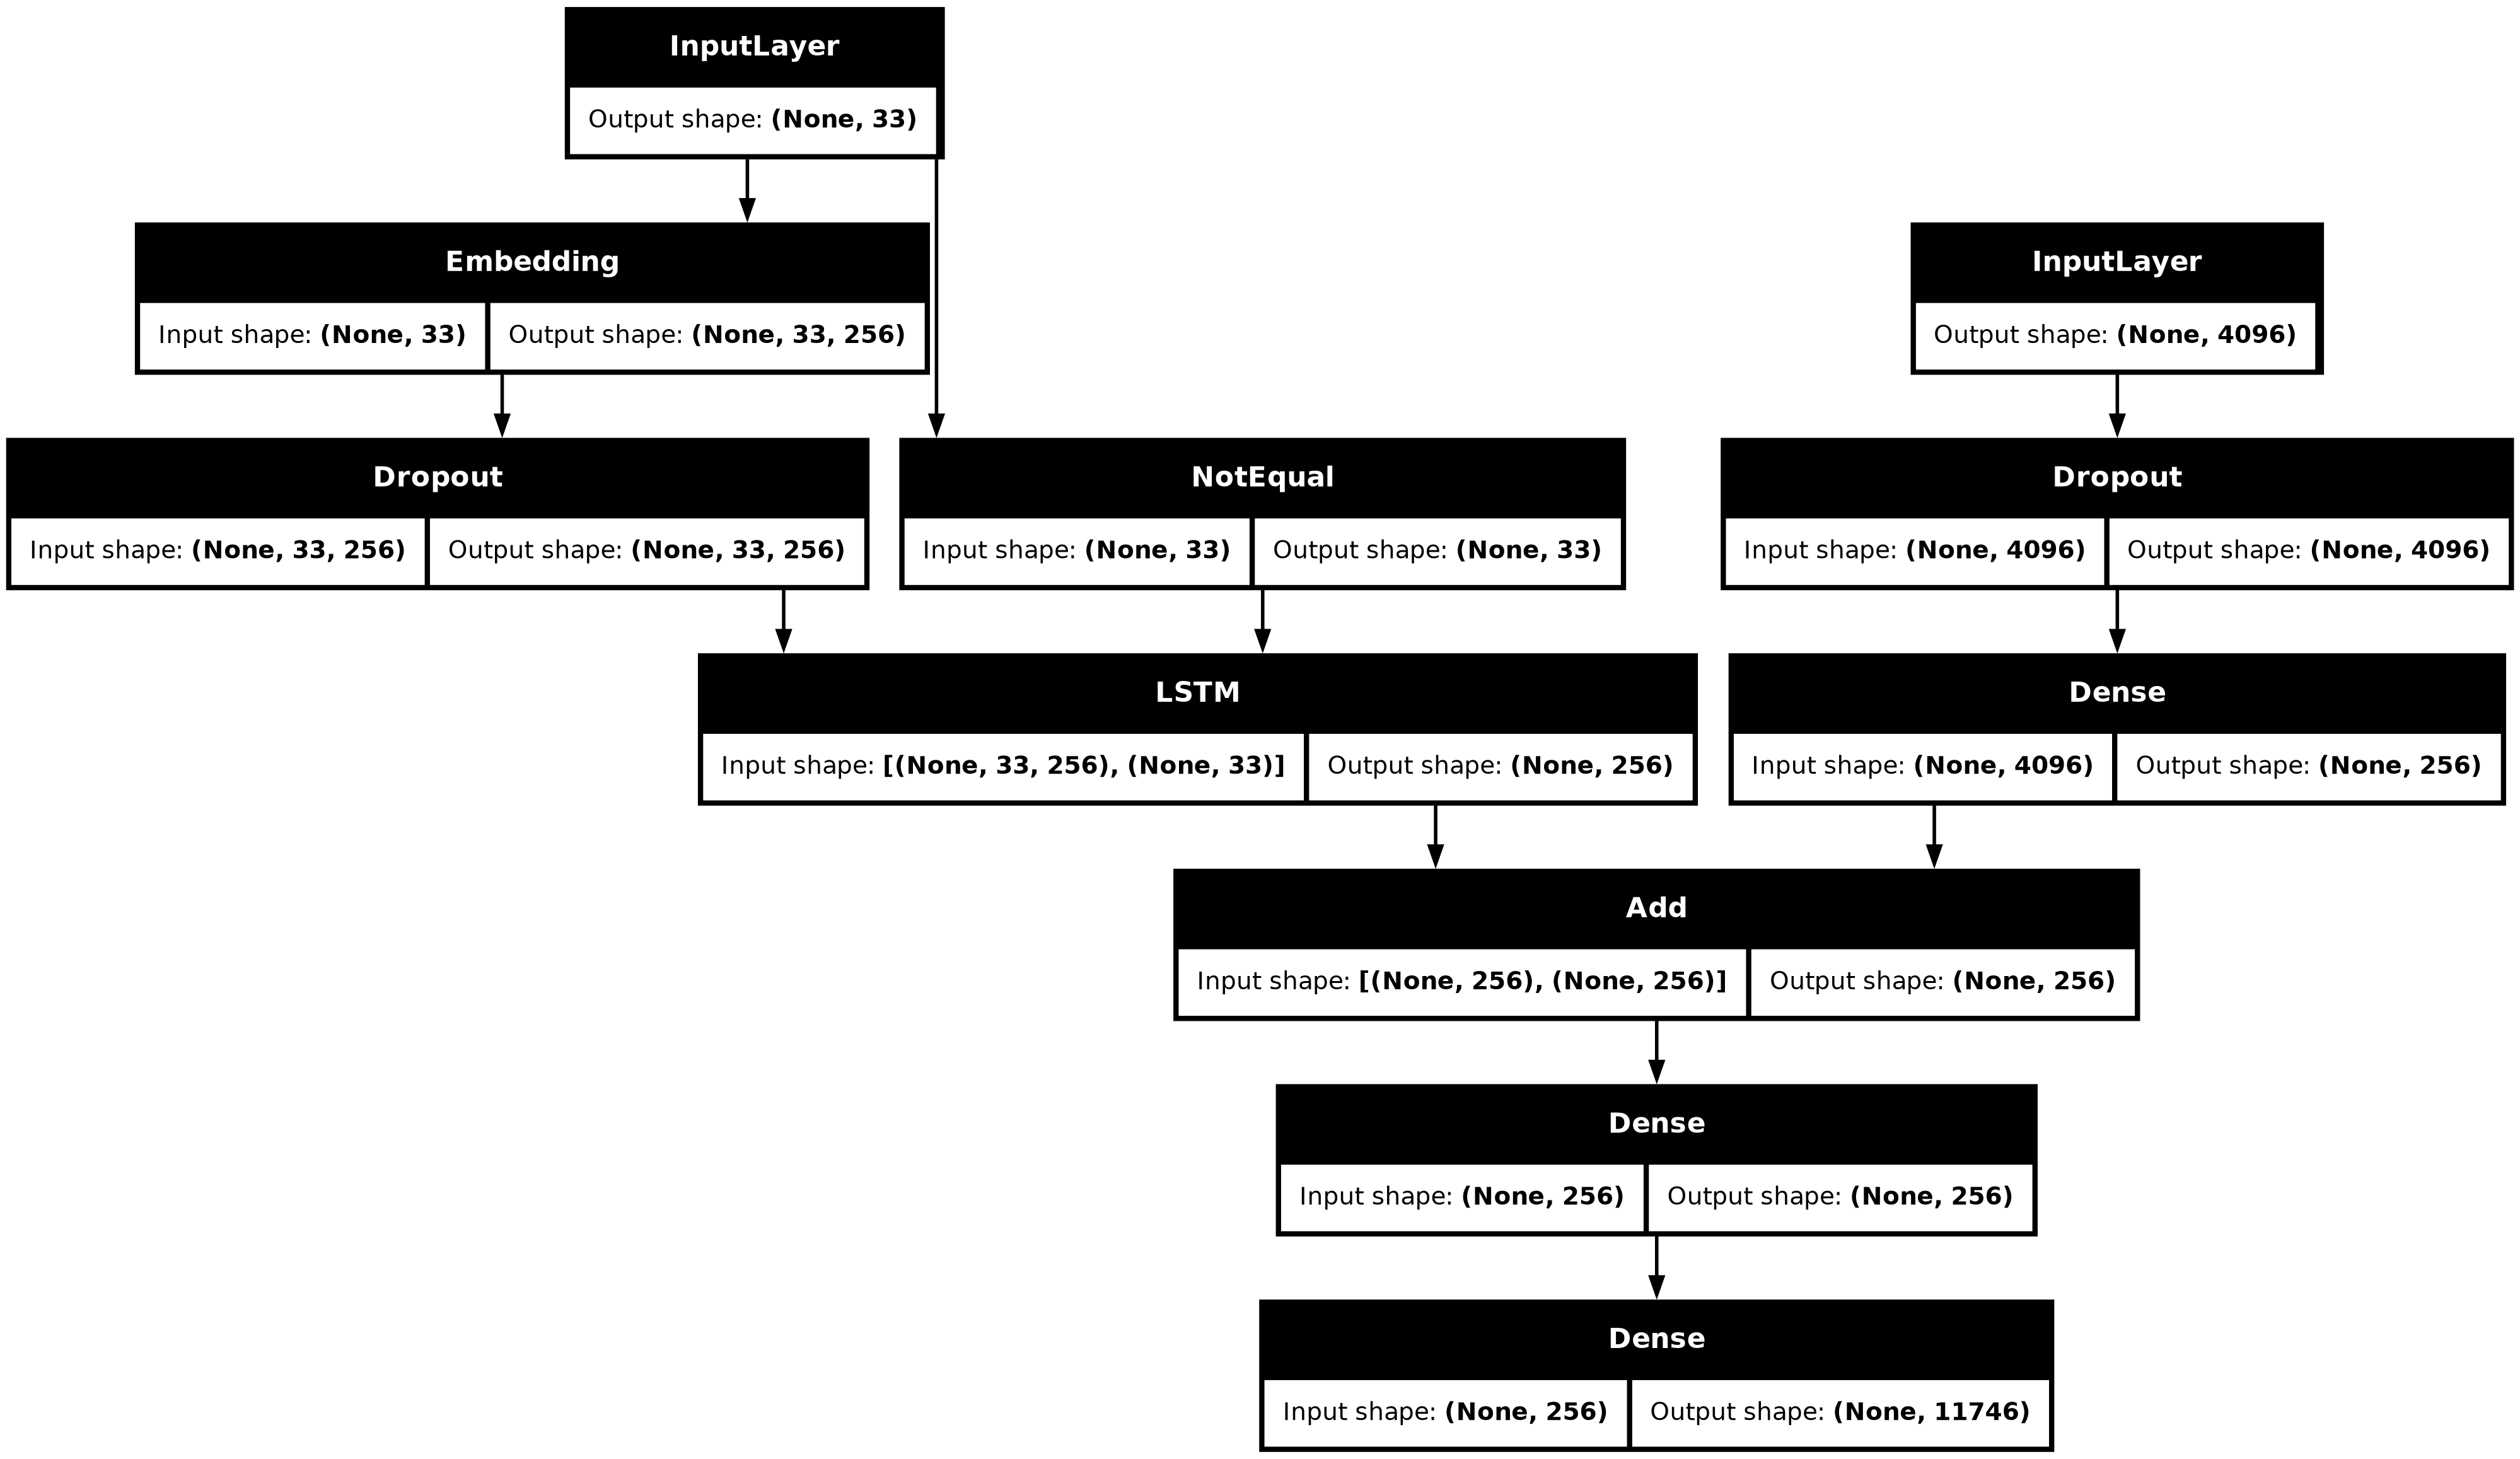

In [16]:
#Encoder model
#Image Feature layers
inputs1=Input(shape=(4096,),name="image")
fe1=Dropout(0.4)(inputs1)
fe2=Dense(256,activation='relu')(fe1)
#Sequence Feature Layers
inputs2=Input(shape=(max_length,),name="text")
se1=Embedding(vocab_size,256,mask_zero=True)(inputs2)
se2=Dropout(0.4)(se1)
se3=LSTM(256,return_sequences=False,use_cudnn=False)(se2)


#Decoder Model
decoder1=add([fe2,se3])
decoder2=Dense(256,activation='relu')(decoder1)
outputs=Dense(vocab_size,activation='softmax')(decoder2)

model=Model(inputs=[inputs1,inputs2],outputs=outputs)
model.compile(loss='categorical_crossentropy',optimizer='adam')

plot_model(model,show_shapes=True)


In [17]:
epochs=40
batch_size=32
steps=len(train)//batch_size

for i in range(epochs):
    generator=data_generator(train,mapping,features,tokenizer,max_length,vocab_size,batch_size)
    model.fit(generator, epochs=1,steps_per_epoch=steps,verbose=1)

  1/227 ━━━━━━━━━━━━━━━━━━━━ 28:33 8s/step - loss: 9.3915

W0000 00:00:1725200391.478212     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200391.526765     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200391.580770     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  2/227 ━━━━━━━━━━━━━━━━━━━━ 18:00 5s/step - loss: 9.3126

W0000 00:00:1725200396.286369     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200396.292098     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200396.334027     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200396.384428     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  3/227 ━━━━━━━━━━━━━━━━━━━━ 17:57 5s/step - loss: 9.1924

W0000 00:00:1725200401.120745     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200401.162170     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200401.206024     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  4/227 ━━━━━━━━━━━━━━━━━━━━ 17:54 5s/step - loss: 9.0269

W0000 00:00:1725200405.933771     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200405.936907     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200405.982172     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200406.032942     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  5/227 ━━━━━━━━━━━━━━━━━━━━ 17:51 5s/step - loss: 8.8730

W0000 00:00:1725200410.786337     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200410.789534     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200410.834592     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200410.885378     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  6/227 ━━━━━━━━━━━━━━━━━━━━ 17:38 5s/step - loss: 8.7369

W0000 00:00:1725200415.452876     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200415.494684     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200415.538762     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  7/227 ━━━━━━━━━━━━━━━━━━━━ 17:36 5s/step - loss: 8.6136

W0000 00:00:1725200420.279788     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200420.328699     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200420.391147     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  8/227 ━━━━━━━━━━━━━━━━━━━━ 17:29 5s/step - loss: 8.5027

W0000 00:00:1725200425.040195     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200425.087520     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200425.138192     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


  9/227 ━━━━━━━━━━━━━━━━━━━━ 17:26 5s/step - loss: 8.4050

W0000 00:00:1725200429.869847     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200429.918530     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200429.971450     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 10/227 ━━━━━━━━━━━━━━━━━━━━ 17:22 5s/step - loss: 8.3182

W0000 00:00:1725200434.694956     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200434.743967     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200434.797779     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 11/227 ━━━━━━━━━━━━━━━━━━━━ 17:18 5s/step - loss: 8.2394

W0000 00:00:1725200439.569293     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200439.572667     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200439.616769     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200439.674753     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 12/227 ━━━━━━━━━━━━━━━━━━━━ 17:15 5s/step - loss: 8.1693

W0000 00:00:1725200444.463652     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200444.512076     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200444.565513     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 14/227 ━━━━━━━━━━━━━━━━━━━━ 15:53 4s/step - loss: 8.0486

W0000 00:00:1725200449.702098     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200449.705208     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200449.750144     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200449.802239     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 15/227 ━━━━━━━━━━━━━━━━━━━━ 15:54 5s/step - loss: 7.9958

W0000 00:00:1725200454.535400     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200454.576946     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200454.620978     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 16/227 ━━━━━━━━━━━━━━━━━━━━ 15:56 5s/step - loss: 7.9481

W0000 00:00:1725200459.505809     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200459.509087     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200459.553261     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200459.603868     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 17/227 ━━━━━━━━━━━━━━━━━━━━ 15:54 5s/step - loss: 7.9036

W0000 00:00:1725200464.236334     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200464.239810     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200464.283312     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200464.332915     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 18/227 ━━━━━━━━━━━━━━━━━━━━ 15:55 5s/step - loss: 7.8611

W0000 00:00:1725200469.178463     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200469.181547     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200469.225917     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200469.278145     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 19/227 ━━━━━━━━━━━━━━━━━━━━ 15:53 5s/step - loss: 7.8218

W0000 00:00:1725200474.033915     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200474.036858     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200474.081979     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200474.134888     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 20/227 ━━━━━━━━━━━━━━━━━━━━ 15:52 5s/step - loss: 7.7852

W0000 00:00:1725200478.940899     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200478.943928     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200478.987628     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200479.037763     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 21/227 ━━━━━━━━━━━━━━━━━━━━ 15:53 5s/step - loss: 7.7505

W0000 00:00:1725200484.039134     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200484.042283     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200484.086303     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200484.141821     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 22/227 ━━━━━━━━━━━━━━━━━━━━ 15:52 5s/step - loss: 7.7175

W0000 00:00:1725200489.083793     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200489.124974     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200489.170667     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 24/227 ━━━━━━━━━━━━━━━━━━━━ 15:08 4s/step - loss: 7.6566

W0000 00:00:1725200494.355790     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200494.404708     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200494.458627     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 26/227 ━━━━━━━━━━━━━━━━━━━━ 14:28 4s/step - loss: 7.6020

W0000 00:00:1725200499.540727     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200499.543973     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200499.587786     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200499.639753     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 27/227 ━━━━━━━━━━━━━━━━━━━━ 14:28 4s/step - loss: 7.5771

W0000 00:00:1725200504.371581     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200504.419897     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200504.473110     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 28/227 ━━━━━━━━━━━━━━━━━━━━ 14:29 4s/step - loss: 7.5532

W0000 00:00:1725200509.491789     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200509.494961     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200509.538853     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200509.589112     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 29/227 ━━━━━━━━━━━━━━━━━━━━ 14:30 4s/step - loss: 7.5302

W0000 00:00:1725200514.571420     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200514.619762     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200514.677230     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 30/227 ━━━━━━━━━━━━━━━━━━━━ 14:32 4s/step - loss: 7.5082

W0000 00:00:1725200519.947725     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200519.951364     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200519.995829     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200520.051322     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 31/227 ━━━━━━━━━━━━━━━━━━━━ 14:33 4s/step - loss: 7.4871

W0000 00:00:1725200525.175337     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200525.178751     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200525.223986     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200525.277149     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 33/227 ━━━━━━━━━━━━━━━━━━━━ 14:02 4s/step - loss: 7.4471

W0000 00:00:1725200530.481994     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200530.485440     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200530.529034     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200530.580140     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 34/227 ━━━━━━━━━━━━━━━━━━━━ 14:03 4s/step - loss: 7.4282

W0000 00:00:1725200535.701852     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200535.749454     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200535.806495     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 35/227 ━━━━━━━━━━━━━━━━━━━━ 14:03 4s/step - loss: 7.4097

W0000 00:00:1725200540.837801     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200540.886657     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200540.940111     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 36/227 ━━━━━━━━━━━━━━━━━━━━ 14:03 4s/step - loss: 7.3919

W0000 00:00:1725200546.037342     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200546.085790     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200546.139068     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 37/227 ━━━━━━━━━━━━━━━━━━━━ 14:04 4s/step - loss: 7.3746

W0000 00:00:1725200551.404655     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200551.408032     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200551.451773     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200551.503320     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 38/227 ━━━━━━━━━━━━━━━━━━━━ 14:03 4s/step - loss: 7.3579

W0000 00:00:1725200556.523381     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200556.526762     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200556.570890     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200556.623429     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 39/227 ━━━━━━━━━━━━━━━━━━━━ 14:02 4s/step - loss: 7.3417

W0000 00:00:1725200561.803391     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200561.806462     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200561.851480     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200561.902880     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 40/227 ━━━━━━━━━━━━━━━━━━━━ 14:02 5s/step - loss: 7.3260

W0000 00:00:1725200567.111089     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200567.114740     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200567.159192     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200567.217148     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 41/227 ━━━━━━━━━━━━━━━━━━━━ 14:01 5s/step - loss: 7.3108

W0000 00:00:1725200572.466829     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200572.470521     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200572.515104     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200572.568403     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 42/227 ━━━━━━━━━━━━━━━━━━━━ 13:59 5s/step - loss: 7.2961

W0000 00:00:1725200577.628520     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200577.632464     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200577.676308     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200577.728338     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 43/227 ━━━━━━━━━━━━━━━━━━━━ 13:58 5s/step - loss: 7.2817

W0000 00:00:1725200582.800363     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200582.803805     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200582.847224     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200582.901512     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 44/227 ━━━━━━━━━━━━━━━━━━━━ 13:56 5s/step - loss: 7.2678

W0000 00:00:1725200588.074860     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200588.078468     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200588.122367     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200588.174099     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 45/227 ━━━━━━━━━━━━━━━━━━━━ 13:54 5s/step - loss: 7.2541

W0000 00:00:1725200593.139706     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200593.142851     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200593.186049     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200593.237465     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 46/227 ━━━━━━━━━━━━━━━━━━━━ 13:50 5s/step - loss: 7.2408

W0000 00:00:1725200598.083380     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200598.124559     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200598.169558     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 47/227 ━━━━━━━━━━━━━━━━━━━━ 13:48 5s/step - loss: 7.2277

W0000 00:00:1725200603.218471     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200603.225778     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200603.265185     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200603.316635     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 48/227 ━━━━━━━━━━━━━━━━━━━━ 13:46 5s/step - loss: 7.2148

W0000 00:00:1725200608.400212     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200608.403325     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200608.448285     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200608.498393     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 49/227 ━━━━━━━━━━━━━━━━━━━━ 13:43 5s/step - loss: 7.2021

W0000 00:00:1725200613.569046     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200613.609687     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200613.652700     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 52/227 ━━━━━━━━━━━━━━━━━━━━ 13:00 4s/step - loss: 7.1663

W0000 00:00:1725200618.902390     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200618.949558     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200619.001637     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 54/227 ━━━━━━━━━━━━━━━━━━━━ 12:39 4s/step - loss: 7.1436

W0000 00:00:1725200624.135309     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200624.182750     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200624.235498     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 55/227 ━━━━━━━━━━━━━━━━━━━━ 12:37 4s/step - loss: 7.1327

W0000 00:00:1725200629.292506     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200629.334057     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200629.386532     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 56/227 ━━━━━━━━━━━━━━━━━━━━ 12:35 4s/step - loss: 7.1222

W0000 00:00:1725200634.417719     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200634.468964     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200634.525047     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 57/227 ━━━━━━━━━━━━━━━━━━━━ 12:33 4s/step - loss: 7.1121

W0000 00:00:1725200639.632499     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200639.681553     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200639.734952     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 58/227 ━━━━━━━━━━━━━━━━━━━━ 12:31 4s/step - loss: 7.1021

W0000 00:00:1725200644.902390     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200644.905700     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200644.949713     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200645.001891     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 60/227 ━━━━━━━━━━━━━━━━━━━━ 12:12 4s/step - loss: 7.0827

W0000 00:00:1725200650.276342     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200650.279560     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200650.323592     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200650.375557     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 61/227 ━━━━━━━━━━━━━━━━━━━━ 12:10 4s/step - loss: 7.0734

W0000 00:00:1725200655.382406     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200655.431138     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200655.484920     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 62/227 ━━━━━━━━━━━━━━━━━━━━ 12:08 4s/step - loss: 7.0641

W0000 00:00:1725200660.628634     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200660.631832     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200660.676792     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200660.729867     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 63/227 ━━━━━━━━━━━━━━━━━━━━ 12:05 4s/step - loss: 7.0551

W0000 00:00:1725200665.753688     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200665.797270     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200665.842448     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 64/227 ━━━━━━━━━━━━━━━━━━━━ 12:02 4s/step - loss: 7.0463

W0000 00:00:1725200670.894693     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200670.897783     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200670.941184     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200670.992252     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 66/227 ━━━━━━━━━━━━━━━━━━━━ 11:45 4s/step - loss: 7.0290

W0000 00:00:1725200676.272775     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200676.320175     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200676.373921     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 67/227 ━━━━━━━━━━━━━━━━━━━━ 11:43 4s/step - loss: 7.0206

W0000 00:00:1725200681.494208     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200681.497318     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200681.542216     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200681.597631     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 68/227 ━━━━━━━━━━━━━━━━━━━━ 11:40 4s/step - loss: 7.0124

W0000 00:00:1725200686.628953     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200686.631822     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200686.676288     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200686.727069     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 69/227 ━━━━━━━━━━━━━━━━━━━━ 11:37 4s/step - loss: 7.0044

W0000 00:00:1725200691.809153     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200691.812300     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200691.857048     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200691.909817     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 71/227 ━━━━━━━━━━━━━━━━━━━━ 11:21 4s/step - loss: 6.9887

W0000 00:00:1725200697.082981     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200697.086100     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200697.129983     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200697.181309     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 72/227 ━━━━━━━━━━━━━━━━━━━━ 11:18 4s/step - loss: 6.9810

W0000 00:00:1725200702.167290     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200702.170356     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200702.213960     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200702.265780     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 73/227 ━━━━━━━━━━━━━━━━━━━━ 11:15 4s/step - loss: 6.9734

W0000 00:00:1725200707.276113     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200707.317656     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200707.361744     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 74/227 ━━━━━━━━━━━━━━━━━━━━ 11:12 4s/step - loss: 6.9659

W0000 00:00:1725200712.519866     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200712.569387     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200712.623795     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 75/227 ━━━━━━━━━━━━━━━━━━━━ 11:10 4s/step - loss: 6.9585

W0000 00:00:1725200717.689881     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200717.693030     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200717.737007     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200717.789110     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 76/227 ━━━━━━━━━━━━━━━━━━━━ 11:07 4s/step - loss: 6.9513

W0000 00:00:1725200722.908035     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200722.911228     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200722.955027     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200723.012845     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 77/227 ━━━━━━━━━━━━━━━━━━━━ 11:04 4s/step - loss: 6.9441

W0000 00:00:1725200728.146460     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200728.149669     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200728.193167     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200728.250507     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 78/227 ━━━━━━━━━━━━━━━━━━━━ 11:01 4s/step - loss: 6.9371

W0000 00:00:1725200733.361317     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200733.364405     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200733.408243     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200733.459644     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 82/227 ━━━━━━━━━━━━━━━━━━━━ 10:22 4s/step - loss: 6.9101

W0000 00:00:1725200739.186402     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200739.189701     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200739.234236     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200739.287062     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 83/227 ━━━━━━━━━━━━━━━━━━━━ 10:20 4s/step - loss: 6.9036

W0000 00:00:1725200744.554331     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200744.603020     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200744.656991     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 84/227 ━━━━━━━━━━━━━━━━━━━━ 10:17 4s/step - loss: 6.8972

W0000 00:00:1725200749.805216     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200749.808407     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200749.853116     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200749.905159     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 85/227 ━━━━━━━━━━━━━━━━━━━━ 10:14 4s/step - loss: 6.8909

W0000 00:00:1725200755.008748     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200755.011749     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200755.055750     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200755.107789     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 87/227 ━━━━━━━━━━━━━━━━━━━━ 10:00 4s/step - loss: 6.8785

W0000 00:00:1725200760.437082     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200760.440420     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200760.484855     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200760.539904     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 89/227 ━━━━━━━━━━━━━━━━━━━━ 9:46 4s/step - loss: 6.8665

W0000 00:00:1725200765.773916     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200765.821679     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200765.873992     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 90/227 ━━━━━━━━━━━━━━━━━━━━ 9:44 4s/step - loss: 6.8606

W0000 00:00:1725200771.057470     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200771.062891     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200771.104848     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200771.157559     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 91/227 ━━━━━━━━━━━━━━━━━━━━ 9:41 4s/step - loss: 6.8548

W0000 00:00:1725200776.487593     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200776.490772     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200776.535779     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200776.588637     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 92/227 ━━━━━━━━━━━━━━━━━━━━ 9:38 4s/step - loss: 6.8490

W0000 00:00:1725200781.551997     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200781.593269     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200781.637028     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 94/227 ━━━━━━━━━━━━━━━━━━━━ 9:25 4s/step - loss: 6.8377

W0000 00:00:1725200786.879493     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200786.928127     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200786.981533     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 97/227 ━━━━━━━━━━━━━━━━━━━━ 9:02 4s/step - loss: 6.8213

W0000 00:00:1725200792.443443     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200792.492227     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200792.544847     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 98/227 ━━━━━━━━━━━━━━━━━━━━ 8:59 4s/step - loss: 6.8159

W0000 00:00:1725200797.514066     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200797.517131     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200797.562106     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200797.614857     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 99/227 ━━━━━━━━━━━━━━━━━━━━ 8:57 4s/step - loss: 6.8106

W0000 00:00:1725200802.708207     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200802.711274     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200802.755375     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200802.806508     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


100/227 ━━━━━━━━━━━━━━━━━━━━ 8:54 4s/step - loss: 6.8053

W0000 00:00:1725200808.107040     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200808.110233     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200808.153644     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200808.207127     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


101/227 ━━━━━━━━━━━━━━━━━━━━ 8:51 4s/step - loss: 6.8001

W0000 00:00:1725200813.348236     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200813.351379     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200813.396322     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200813.448500     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


103/227 ━━━━━━━━━━━━━━━━━━━━ 8:39 4s/step - loss: 6.7898

W0000 00:00:1725200818.845752     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200818.848895     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200818.893144     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200818.943885     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


105/227 ━━━━━━━━━━━━━━━━━━━━ 8:27 4s/step - loss: 6.7798

W0000 00:00:1725200824.100384     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200824.103525     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200824.148004     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200824.206409     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


108/227 ━━━━━━━━━━━━━━━━━━━━ 8:07 4s/step - loss: 6.7652

W0000 00:00:1725200829.429300     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200829.476460     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200829.529030     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


110/227 ━━━━━━━━━━━━━━━━━━━━ 7:55 4s/step - loss: 6.7556

W0000 00:00:1725200834.928854     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200834.931892     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200834.976114     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200835.027158     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


111/227 ━━━━━━━━━━━━━━━━━━━━ 7:53 4s/step - loss: 6.7510

W0000 00:00:1725200840.156459     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200840.159471     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200840.202943     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200840.253057     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


112/227 ━━━━━━━━━━━━━━━━━━━━ 7:50 4s/step - loss: 6.7463

W0000 00:00:1725200845.251114     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200845.292639     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200845.336541     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


116/227 ━━━━━━━━━━━━━━━━━━━━ 7:23 4s/step - loss: 6.7284

W0000 00:00:1725200850.752749     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200850.755825     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200850.801451     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200850.858420     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


117/227 ━━━━━━━━━━━━━━━━━━━━ 7:20 4s/step - loss: 6.7241

W0000 00:00:1725200855.876809     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200855.880032     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200855.924072     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200855.975712     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


118/227 ━━━━━━━━━━━━━━━━━━━━ 7:17 4s/step - loss: 6.7198

W0000 00:00:1725200861.008530     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200861.011704     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200861.056378     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200861.112794     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


120/227 ━━━━━━━━━━━━━━━━━━━━ 7:06 4s/step - loss: 6.7114

W0000 00:00:1725200866.316543     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200866.319989     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200866.363951     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200866.416690     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


121/227 ━━━━━━━━━━━━━━━━━━━━ 7:04 4s/step - loss: 6.7072

W0000 00:00:1725200871.631292     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200871.672874     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200871.718498     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


123/227 ━━━━━━━━━━━━━━━━━━━━ 6:53 4s/step - loss: 6.6990

W0000 00:00:1725200877.039064     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200877.042280     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200877.087128     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200877.140072     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


125/227 ━━━━━━━━━━━━━━━━━━━━ 6:43 4s/step - loss: 6.6909

W0000 00:00:1725200882.449038     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200882.496377     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200882.548658     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


127/227 ━━━━━━━━━━━━━━━━━━━━ 6:33 4s/step - loss: 6.6831

W0000 00:00:1725200887.837231     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200887.840236     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200887.885189     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200887.937594     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


129/227 ━━━━━━━━━━━━━━━━━━━━ 6:24 4s/step - loss: 6.6753

W0000 00:00:1725200893.081053     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200893.127363     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200893.178992     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


130/227 ━━━━━━━━━━━━━━━━━━━━ 6:20 4s/step - loss: 6.6715

W0000 00:00:1725200898.136458     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200898.177654     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200898.223187     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


132/227 ━━━━━━━━━━━━━━━━━━━━ 6:11 4s/step - loss: 6.6639

W0000 00:00:1725200903.671327     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200903.719812     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200903.773262     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


135/227 ━━━━━━━━━━━━━━━━━━━━ 5:55 4s/step - loss: 6.6528

W0000 00:00:1725200908.942587     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200908.984270     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200909.028432     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


136/227 ━━━━━━━━━━━━━━━━━━━━ 5:52 4s/step - loss: 6.6491

W0000 00:00:1725200914.014480     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200914.017533     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200914.061942     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200914.114282     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


137/227 ━━━━━━━━━━━━━━━━━━━━ 5:49 4s/step - loss: 6.6454

W0000 00:00:1725200919.053360     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200919.057765     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200919.100116     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200919.151547     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


138/227 ━━━━━━━━━━━━━━━━━━━━ 5:46 4s/step - loss: 6.6418

W0000 00:00:1725200924.122679     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200924.126231     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200924.170907     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200924.224091     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


139/227 ━━━━━━━━━━━━━━━━━━━━ 5:42 4s/step - loss: 6.6382

W0000 00:00:1725200929.323384     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200929.372089     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200929.425663     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


140/227 ━━━━━━━━━━━━━━━━━━━━ 5:39 4s/step - loss: 6.6346

W0000 00:00:1725200934.541600     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200934.544821     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200934.589459     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200934.645215     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


141/227 ━━━━━━━━━━━━━━━━━━━━ 5:36 4s/step - loss: 6.6310

W0000 00:00:1725200939.671638     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200939.713339     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200939.757202     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


142/227 ━━━━━━━━━━━━━━━━━━━━ 5:33 4s/step - loss: 6.6275

W0000 00:00:1725200944.672802     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200944.714523     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200944.760077     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


143/227 ━━━━━━━━━━━━━━━━━━━━ 5:30 4s/step - loss: 6.6240

W0000 00:00:1725200949.795339     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200949.798475     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200949.843070     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200949.894293     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


146/227 ━━━━━━━━━━━━━━━━━━━━ 5:14 4s/step - loss: 6.6137

W0000 00:00:1725200955.087887     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200955.129321     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200955.175012     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


147/227 ━━━━━━━━━━━━━━━━━━━━ 5:11 4s/step - loss: 6.6103

W0000 00:00:1725200960.271493     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200960.274606     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200960.318197     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200960.369720     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


148/227 ━━━━━━━━━━━━━━━━━━━━ 5:08 4s/step - loss: 6.6069

W0000 00:00:1725200965.533577     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200965.536733     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200965.580737     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200965.631353     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


149/227 ━━━━━━━━━━━━━━━━━━━━ 5:05 4s/step - loss: 6.6036

W0000 00:00:1725200970.767072     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200970.816395     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200970.870534     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


150/227 ━━━━━━━━━━━━━━━━━━━━ 5:01 4s/step - loss: 6.6002

W0000 00:00:1725200975.822801     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200975.825977     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200975.869773     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200975.921550     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


155/227 ━━━━━━━━━━━━━━━━━━━━ 4:35 4s/step - loss: 6.5838

W0000 00:00:1725200981.435292     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200981.438518     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200981.481869     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200981.532864     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


157/227 ━━━━━━━━━━━━━━━━━━━━ 4:27 4s/step - loss: 6.5774

W0000 00:00:1725200986.816632     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200986.857613     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200986.900850     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


158/227 ━━━━━━━━━━━━━━━━━━━━ 4:23 4s/step - loss: 6.5742

W0000 00:00:1725200991.931852     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200991.934954     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200991.979508     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200992.032270     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


163/227 ━━━━━━━━━━━━━━━━━━━━ 3:59 4s/step - loss: 6.5583

W0000 00:00:1725200997.685655     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200997.688700     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200997.733174     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725200997.785190     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


167/227 ━━━━━━━━━━━━━━━━━━━━ 3:41 4s/step - loss: 6.5459

W0000 00:00:1725201003.115713     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725201003.162487     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725201003.212788     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


170/227 ━━━━━━━━━━━━━━━━━━━━ 3:28 4s/step - loss: 6.5367

W0000 00:00:1725201008.453826     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725201008.500646     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725201008.552481     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


178/227 ━━━━━━━━━━━━━━━━━━━━ 2:53 4s/step - loss: 6.5126

W0000 00:00:1725201019.520973     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725201019.523978     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725201019.568568     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725201019.620844     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


180/227 ━━━━━━━━━━━━━━━━━━━━ 2:46 4s/step - loss: 6.5067

W0000 00:00:1725201024.803315     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725201024.806362     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725201024.851509     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725201024.905039     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


190/227 ━━━━━━━━━━━━━━━━━━━━ 2:07 3s/step - loss: 6.4781

W0000 00:00:1725201041.857868     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725201041.861260     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725201041.904549     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725201041.961954     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


191/227 ━━━━━━━━━━━━━━━━━━━━ 2:04 3s/step - loss: 6.4753

W0000 00:00:1725201047.174347     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725201047.224155     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725201047.278910     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


193/227 ━━━━━━━━━━━━━━━━━━━━ 1:57 3s/step - loss: 6.4697

W0000 00:00:1725201052.610047     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725201052.613276     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725201052.656695     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725201052.713976     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


198/227 ━━━━━━━━━━━━━━━━━━━━ 1:38 3s/step - loss: 6.4559

W0000 00:00:1725201058.494626     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725201058.497731     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725201058.541803     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725201058.593536     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


199/227 ━━━━━━━━━━━━━━━━━━━━ 1:35 3s/step - loss: 6.4532

W0000 00:00:1725201063.621807     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725201063.624843     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725201063.670171     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725201063.722805     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


201/227 ━━━━━━━━━━━━━━━━━━━━ 1:28 3s/step - loss: 6.4478

W0000 00:00:1725201069.130643     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725201069.133970     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725201069.178954     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725201069.232375     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


203/227 ━━━━━━━━━━━━━━━━━━━━ 1:21 3s/step - loss: 6.4425

W0000 00:00:1725201074.413015     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725201074.416119     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725201074.461487     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725201074.514769     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


207/227 ━━━━━━━━━━━━━━━━━━━━ 1:06 3s/step - loss: 6.4319

W0000 00:00:1725201079.956439     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725201079.997585     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725201080.040760     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


215/227 ━━━━━━━━━━━━━━━━━━━━ 38s 3s/step - loss: 6.4111

W0000 00:00:1725201086.126903     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725201086.130081     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725201086.175266     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725201086.228425     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


217/227 ━━━━━━━━━━━━━━━━━━━━ 32s 3s/step - loss: 6.4060

W0000 00:00:1725201091.536323     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725201091.539591     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725201091.583545     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725201091.635723     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


219/227 ━━━━━━━━━━━━━━━━━━━━ 25s 3s/step - loss: 6.4009

W0000 00:00:1725201097.051818     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725201097.054704     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725201097.099458     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725201097.151898     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


220/227 ━━━━━━━━━━━━━━━━━━━━ 22s 3s/step - loss: 6.3984

W0000 00:00:1725201102.309845     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725201102.351463     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725201102.396972     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


222/227 ━━━━━━━━━━━━━━━━━━━━ 16s 3s/step - loss: 6.3934

W0000 00:00:1725201107.632385     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725201107.679455     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725201107.731595     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


225/227 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - loss: 6.3859

W0000 00:00:1725201113.116863     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725201113.165969     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725201113.220580     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


226/227 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - loss: 6.3834

W0000 00:00:1725201118.359477     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725201118.400423     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1725201118.445942     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


227/227 ━━━━━━━━━━━━━━━━━━━━ 735s 3s/step - loss: 6.3784
227/227 ━━━━━━━━━━━━━━━━━━━━ 58s 256ms/step - loss: 4.6667
227/227 ━━━━━━━━━━━━━━━━━━━━ 60s 262ms/step - loss: 4.0556
227/227 ━━━━━━━━━━━━━━━━━━━━ 59s 259ms/step - loss: 3.6924
227/227 ━━━━━━━━━━━━━━━━━━━━ 60s 263ms/step - loss: 3.4255
227/227 ━━━━━━━━━━━━━━━━━━━━ 58s 258ms/step - loss: 3.2308
227/227 ━━━━━━━━━━━━━━━━━━━━ 59s 262ms/step - loss: 3.0733
227/227 ━━━━━━━━━━━━━━━━━━━━ 59s 261ms/step - loss: 2.9498
227/227 ━━━━━━━━━━━━━━━━━━━━ 58s 257ms/step - loss: 2.8491
227/227 ━━━━━━━━━━━━━━━━━━━━ 58s 255ms/step - loss: 2.7675
227/227 ━━━━━━━━━━━━━━━━━━━━ 58s 256ms/step - loss: 2.6881
227/227 ━━━━━━━━━━━━━━━━━━━━ 58s 257ms/step - loss: 2.6138
227/227 ━━━━━━━━━━━━━━━━━━━━ 59s 258ms/step - loss: 2.5524
227/227 ━━━━━━━━━━━━━━━━━━━━ 58s 257ms/step - loss: 2.4945
227/227 ━━━━━━━━━━━━━━━━━━━━ 58s 257ms/step - loss: 2.4468
227/227 ━━━━━━━━━━━━━━━━━━━━ 60s 264ms/step - loss: 2.3919
227/227 ━━━━━━━━━━━━━━━━━━━━ 58s 254ms/step - loss: 2.3476

In [18]:
model.save(working_dir+'/best_model111.h5')


In [19]:
#Generate Captions for images
def idx_to_word(integer,tokenizer):
    for word,index in tokenizer.word_index.items():
        if(index==integer):
            return word
    return None




In [20]:
#Generate Caption for an image

def predict_caption(model,image,tokenizer,max_length):
    in_text='startseq'
    for i in range(max_length):
        sequence=tokenizer.texts_to_sequences([in_text])[0]
        sequence=pad_sequences([sequence],max_length)
        yhat=model.predict([image,sequence],verbose=0)
        yhat=np.argmax(yhat)
        word=idx_to_word(yhat,tokenizer)
        if word is None:
            break
        in_text += " " + word
        if word=='endseq':
            break
    return in_text
        
    

In [21]:
#Validate with Test data
from nltk.translate.bleu_score import corpus_bleu
actual,predicted=list(),list()

for key in tqdm(test):
    captions=mapping[key]
    y_pred=predict_caption(model,features[key],tokenizer,max_length)
    y_pred=y_pred.split()
    actual_captions=[caption.split() for caption in captions]
    actual.append(actual_captions)
    predicted.append(y_pred)
    

  0%|          | 0/810 [00:00<?, ?it/s]

In [22]:
print("BLEU-1: %f" %corpus_bleu(actual,predicted,weights=(1.0,0,0,0)))
print("BLEU-2: %f" %corpus_bleu(actual,predicted,weights=(0.5,0.5,0,0)))

BLEU-1: 0.261416
BLEU-2: 0.128924


# VISUALIZE THE RESULTS

In [23]:
from PIL import Image
import matplotlib.pyplot as plt

def generate_caption(image_name):
    image_id=image_name.split('.')[0]
    image_path=os.path.join(Base_dir,"Images",image_name)
    image=Image.open(image_path)
    captions=mapping[image_id]
    print('-------Actual-------')
    for caption in captions:
        print(caption)
    y_pred=predict_caption(model,features[image_id],tokenizer,max_length)
    print('-------Predicted---------')
    print(y_pred)
    plt.imshow(image)


-------Actual-------
startseq"a dog shakes its head near the shore red ball next to it ."endseq
startseqwhite dog shakes on the edge of beach with an orange ballendseq
startseq"dog with orange ball at feet stands on shore shaking off water"endseq
startseqwhite dog playing with red ball on the shore near the waterendseq
startseqwhite dog with brown ears standing near water with head turned to one sideendseq
-------Predicted---------
startseq a brown dog with red collar bites the water endseq


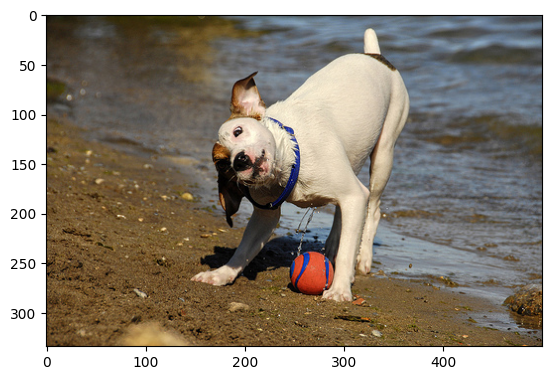

In [24]:
generate_caption("1012212859_01547e3f17.jpg")

-------Actual-------
startseqman uses ice picks and crampons to scale iceendseq
startseqan ice climber in blue jacket and black pants is scaling frozen ice wallendseq
startseqan ice climber scaling frozen waterfallendseq
startseqperson in blue and red ice climbing with two picksendseq
startseqclimber climbing an ice wallendseq
-------Predicted---------
startseq a person in red and orange suit and helmet is heating container in the air endseq


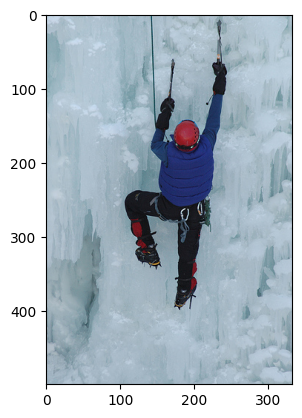

In [25]:
generate_caption("102455176_5f8ead62d5.jpg")

-------Actual-------
startseqwoman crouches near three dogs in fieldendseq
startseqthree dogs are playing on grassy hill with blue skyendseq
startseqthree dogs are standing in the grass and person is sitting next to themendseq
startseqthree dogs on grassy hillendseq
startseqthree dogs stand in grassy field while person kneels nearbyendseq
-------Predicted---------
startseq two dogs one black and one black are running in grassy field endseq


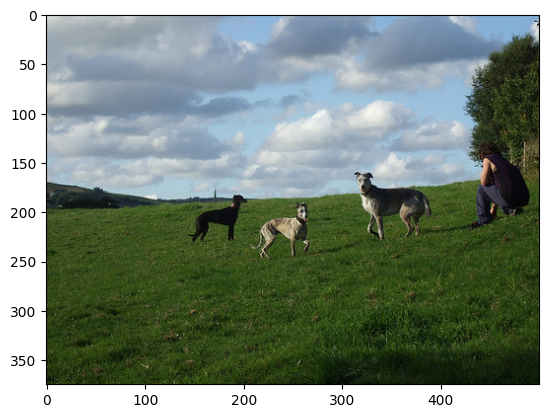

In [26]:
generate_caption("1032122270_ea6f0beedb.jpg")

-------Actual-------
startseqboy in his blue swim shorts at the beachendseq
startseqboy smiles for the camera at beachendseq
startseqyoung boy in swimming trunks is walking with his arms outstretched on the beachendseq
startseqchildren playing on the beachendseq
startseqthe boy is playing on the shore of an oceanendseq
-------Predicted---------
startseq a boy in blue shorts carrying his mouth 's head at the shore endseq


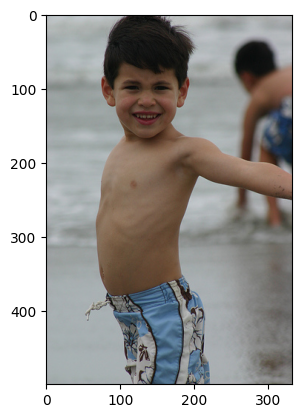

In [27]:
generate_caption("106490881_5a2dd9b7bd.jpg")

-------Actual-------
startseqboy cleans the bubbles off his faceendseq
startseqboy covered in suds has his face wiped cleanendseq
startseqboy is covered in bubblesendseq
startseqchild covered in foam is climbing on black inflatable rampendseq
startseqperson covered in soapy water is getting cleaned offendseq
-------Predicted---------
startseq the man is covered in bubblesendseq water in the foreground endseq


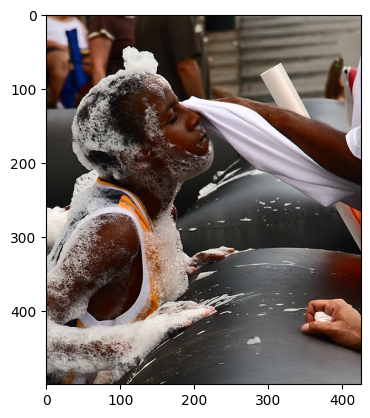

In [28]:
generate_caption("1075881101_d55c46bece.jpg")